In [1]:
import numpy as np
import sys
import time
import h5py
from tqdm import tqdm

import numpy as np
import re
from math import ceil
from sklearn.metrics import average_precision_score
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import pickle
#import pickle5 as pickle

from sklearn.model_selection import train_test_split

from scipy.sparse import load_npz
from glob import glob

from transformers import get_constant_schedule_with_warmup
from sklearn.metrics import precision_score,recall_score,accuracy_score

from src.train import trainModel
from src.dataloader import get_GTEX_v8_Data,getDataPointListGTEX,getData,spliceDataset,h5pyDataset
from src.weight_init import keras_init
from src.losses import categorical_crossentropy_2d
from src.model import SpliceFormer
from src.evaluation_metrics import print_topl_statistics
import umap
#import umap.plot
from sklearn.manifold import trustworthiness
from sklearn.metrics.pairwise import cosine_distances
#import tensorflow as tf

In [2]:
!nvidia-smi

Tue Oct 24 15:33:05 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080        Off | 00000000:01:00.0 Off |                  N/A |
| 30%   39C    P0             ERR! / 320W |      1MiB / 10240MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
rng = np.random.default_rng(23673)

In [4]:
#data_dir = '../Data'

In [5]:
#gtf = None

In [6]:
L = 32
N_GPUS = 8
k = 2
# Hyper-parameters:
# L: Number of convolution kernels
# W: Convolution window size in each residual unit
# AR: Atrous rate in each residual unit

W = np.asarray([11, 11, 11, 11, 11, 11, 11, 11,
                21, 21, 21, 21, 41, 41, 41, 41])
AR = np.asarray([1, 1, 1, 1, 4, 4, 4, 4,
                 10, 10, 10, 10, 25, 25, 25, 25])
BATCH_SIZE = k*6*N_GPUS


CL = 2 * np.sum(AR*(W-1))

In [7]:
SL=5000
CL_max=40000

In [8]:
data_dir = '/odinn/tmp/benediktj/Data/SplicePrediction-GTEX-V8'
setType = 'test'
annotation, gene_to_label, seqData = get_GTEX_v8_Data(data_dir, setType,'annotation_GTEX_v8.txt')

In [9]:
from collections import OrderedDict
import copy

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpliceFormer(CL_max,returnFmap=True)
model.apply(keras_init)
model = model.to(device)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

output_class_labels = ['Null', 'Acceptor', 'Donor']
n_models = 10
#for output_class in [1,2]:
models = [copy.deepcopy(model) for i in range(n_models)]
#[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_2_{}'.format(i))) for i,model in enumerate(models)]
#chunkSize = num_idx/10

#model_m.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_finetune_rnasplice-blood_all_050623_0'))

for i,model in enumerate(models):
    state_dict = torch.load('../Results/PyTorch_Models/transformer_encoder_40k_finetune_rnasplice-blood_all_050623_{}'.format(i))
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)

#model_m.transformerBlock1.transformer.layers[0][0].fn.attend.register_forward_hook(get_activation('attend'))

for model in models:
    model.eval()

In [11]:
BATCH_SIZE=1

In [12]:
specific_anno = annotation[annotation['name']=='CFTR']

In [15]:
test_dataset = spliceDataset(getDataPointListGTEX(specific_anno,gene_to_label,SL,CL_max,shift=SL))
test_dataset.seqData = seqData
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

fmaps = []
outputs = []
targets_a = []
for i,( batch_features,targets) in enumerate(tqdm(test_loader)):
    batch_features = batch_features.type(torch.FloatTensor).to(device)
    targets_full = targets.to(device)
    targets = targets_full[:,:,CL_max//2:-CL_max//2]
    output = [model(batch_features)[0][0,:,:].T.cpu().detach().numpy() for model in models]
    output = np.concatenate(output,axis=1)
    outputs.append(output)
    fmap = [model(batch_features)[-1][0,:,:].T.cpu().detach().numpy() for model in models]
    fmap = np.concatenate(fmap,axis=1)
    fmaps.append(fmap)
    #output = torch.concat([y[0] for y in x],dim=1)
    #fmap = torch.concat([y[1] for y in x],dim=1)
    #output,_,_,_,_,fmap = model(batch_features)
    
    
    targets_a.append(targets[0,:,:].cpu().detach().numpy().T)

100%|█████████████████████████████████████████████████████████████████████████████████| 38/38 [03:02<00:00,  4.81s/it]


In [21]:
x[0][-1].shape

torch.Size([1, 32, 5000])

In [24]:
.shape

torch.Size([1, 320, 5000])

In [16]:
transcript_len = int(specific_anno['tx_end'].values-specific_anno['tx_start'].values)
fmap = np.concatenate(fmaps,axis=0)[:transcript_len,:]
targets = np.concatenate(targets_a,axis=0)[:transcript_len,:]
output = np.concatenate(outputs,axis=0)[:transcript_len,:]

In [17]:
#exons = targets[:,3]
#targets = targets[:,:3]

In [18]:
n_neighbors=50
mapper = umap.UMAP(n_neighbors=n_neighbors,metric='cosine',random_state=42).fit(fmap)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [28]:
sampleIdx = np.random.choice(np.arange(fmap.shape[0]),size=int(np.round(0.75*fmap.shape[0],0)),replace=False)

In [29]:
trustworthiness(fmap[sampleIdx,:], mapper.transform(fmap)[sampleIdx,:],n_neighbors=50,metric='cosine')

MemoryError: Unable to allocate 74.6 GiB for an array with shape (141480, 141480) and data type float32

In [ ]:
#dist = cosine_distances(fmap)

In [ ]:
#np.save('/odinn/tmp/benediktj/Data/SplicePrediction-050422/dist.npy', dist)
#fp = np.lib.format.open_memmap('/odinn/tmp/benediktj/Data/SplicePrediction-050422/dist.npy',dtype=np.float32)

In [19]:
emb = mapper.transform(fmap)

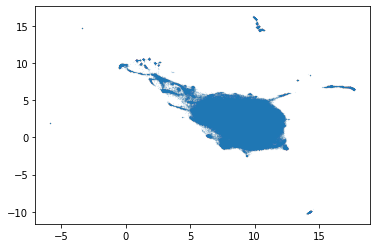

In [20]:
plt.scatter(emb[:,0],emb[:,1],s=0.001)

In [21]:
cmap = plt.get_cmap('tab20') 

In [22]:
nzero_idx = np.nonzero(targets[:,1]+2*targets[:,2])[0]
closest_splice = []
distance_to_splice = []
for i in range(targets.shape[0]):
    tmp = np.absolute(nzero_idx-i)
    closest_idx = np.argmin(tmp)
    distance_to_splice.append(np.min(tmp))
    closest_splice.append(np.argmax(targets[nzero_idx[closest_idx]])-1)

In [23]:
np.argmax(targets[nzero_idx[closest_idx]])

2

In [24]:
np.arange(targets.shape[0])[targets[:,2]==1]

array([   122,    376,  22743,  23665,  24338,  25203,  29117,  31545,
        37153,  51089,  54340,  55386,  56648,  59013,  60321,  62083,
        68798,  79630,  86118, 107808, 110414, 112632, 115033, 122838,
       123757, 126728, 130644, 131783, 134688, 147545, 147745, 162568,
       162958, 168420, 172688, 172906, 184835, 185539, 187232, 187732])

In [25]:
import matplotlib.colors as colors

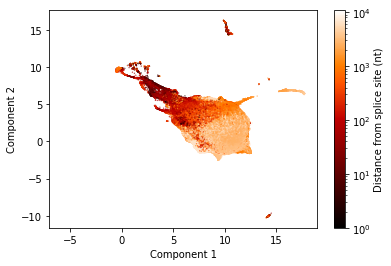

In [26]:
plt.scatter(emb[:,0],emb[:,1],c=distance_to_splice,norm=colors.LogNorm(),cmap='gist_heat',s=0.1)
cbar = plt.colorbar()
cbar.set_label('Distance from splice site (nt)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.savefig('../Results/UmapPlots/CFTR_umap_distance_231023.png', dpi=400)
plt.show()
tmp1 = np.logical_and(emb[:,0]>=1, emb[:,0]<=8)
tmp2 = np.logical_and(emb[:,1]>=-7, emb[:,1]<=-1)
cond1 = np.where(np.logical_and(tmp1,tmp2))
#plt.savefig('../Results/UmapPlots/CFTR_umap_distance_zoom_1.png', dpi=400)
plt.show()

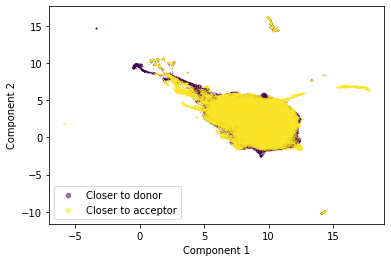

In [27]:
cmap = plt.get_cmap('viridis') 
cond1 = np.array(closest_splice)==1
cond2 = np.array(closest_splice)==0
plt.scatter(emb[cond1,0],emb[cond1,1],color=cmap(0),s=0.05,alpha=0.5,label='Closer to donor')
plt.scatter(emb[cond2,0],emb[cond2,1],color=cmap(255),s=0.05,alpha=0.5,label='Closer to acceptor')
lgnd = plt.legend()
#plt.xlim([1,8])
#plt.ylim([-7,-1])
lgnd.legendHandles[0]._sizes = [20]
lgnd.legendHandles[1]._sizes = [20]
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.savefig('../Results/UmapPlots/CFTR_umap_closest_splice_type_231023.png', dpi=400)

#### PCA

In [30]:
from sklearn.decomposition import PCA,TruncatedSVD

In [31]:
pca = PCA(n_components = 32, random_state=42)

In [32]:
#emb_pca = pca.fit_transform(fmap)
emb_pca = pca.fit_transform((fmap-np.mean(fmap,axis=0))/np.std(fmap,axis=0))

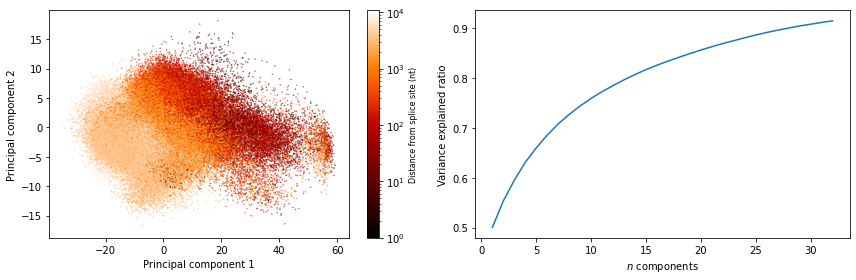

In [33]:
fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2,figsize=(12,4))

pcm = ax1.scatter(emb_pca[:,0],emb_pca[:,1],c=distance_to_splice,norm=colors.LogNorm(),cmap='gist_heat',s=0.1)
cbar = fig.colorbar(pcm, ax=ax1)
cbar.set_label('Distance from splice site (nt)',size=8)
ax1.set_xlabel('Principal component 1')
ax1.set_ylabel('Principal component 2')
#cbar = ax1.colorbar()
#cbar.set_label('Distance from splice site (nt)')
#ax1.scatter(emb_pca[:,0],emb_pca[:,1],s=0.001)
#ax1.scatter(emb_pca[cond1,0],emb_pca[cond1,1],color=cmap(0),alpha=0.5,s=0.05,label='Closer to donor')
#ax1.scatter(emb_pca[cond2,0],emb_pca[cond2,1],color=cmap(255),alpha=0.5,s=0.05,label='Closer to acceptor')
ax2.plot(range(1,33),np.cumsum(pca.explained_variance_ratio_))
ax2.set_xlabel('$n$ components')
ax2.set_ylabel('Variance explained ratio')
plt.tight_layout()
plt.savefig('../Results/UmapPlots/CFTR_pca_231023.png', dpi=300)
plt.show()

In [34]:
#cmap = plt.get_cmap('viridis') 
#fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2,figsize=(12,4))
#cond1 = exons==0
#ax1.scatter(emb_pca[cond1,0],emb_pca[cond1,1],color=cmap(0),s=0.001,label='Intron')
#cond2 = exons==1
#ax1.scatter(emb_pca[cond2,0],emb_pca[cond2,1],color=cmap(255),s=0.001,label='Exon')
#cond3 = targets[:,1]==1
#ax1.scatter(emb_pca[cond3,0],emb_pca[cond3,1],color='red',s=0.1,label='Acceptor')
#cond4 = targets[:,2]==1
#ax1.scatter(emb_pca[cond4,0],emb_pca[cond4,1],color='green',s=0.1,label='Donor')
#lgnd = ax1.legend()
#lgnd.legendHandles[0]._sizes = [20]
#lgnd.legendHandles[1]._sizes = [20]
#lgnd.legendHandles[2]._sizes = [20]
#lgnd.legendHandles[3]._sizes = [20]
#ax1.set_xlabel('Principal component 1')
#ax1.set_ylabel('Principal component 2')

#ax2.plot(range(1,33),np.cumsum(pca.explained_variance_ratio_))
#ax2.set_xlabel('$n$ components')
#ax2.set_ylabel('Variance explained ratio')
#ax2.set_xticks(range(1,33,3))
#plt.savefig('../Results/UmapPlots/CFTR_pca.png', dpi=400)
#plt.show()

In [35]:
print(pca.explained_variance_ratio_[0],pca.explained_variance_ratio_[1])

0.5004277957481577 0.05323020193161923


In [36]:

from scipy.stats import spearmanr

In [39]:
spearmanr(emb_pca[:,0],distance_to_splice)

SpearmanrResult(correlation=-0.5731186419089314, pvalue=0.0)

In [40]:
spearmanr(emb_pca[:,1],distance_to_splice)

SpearmanrResult(correlation=-0.3774300877536861, pvalue=0.0)

In [41]:
0.6305575535931238+0.1140809142874575

0.7446384678805813

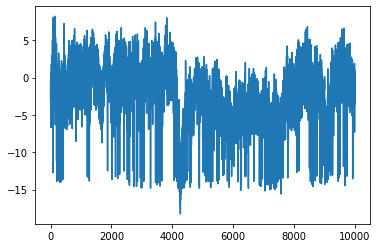

In [39]:
plt.plot(emb_pca[20000:30000,0])
plt.show()

In [ ]:
emb_pca[]